In [1]:
# import packages
import tensorflow as tf
import pandas as pd
import random
import numpy as np 
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Bidirectional, RNN, LSTMCell, Dropout
from tensorflow.keras.models import Model
import joblib
from newspaper import Article

# Fix seed
random.seed(1)
tf.random.set_seed(1)

# Check if GPU is used properly 
print(len(tf.config.experimental.list_physical_devices('GPU')))

1


In [2]:
# import data set
df_t = pd.read_csv('D:/data/ft/True.csv')
df_f = pd.read_csv('D:/data/ft/Fake.csv')
print(df_t.head(5))
print(df_f.head(5))

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   
                                               title  \
0   Donald Trump Sends Out Embarrassing Ne

In [3]:
# Generate label
df_t['target'] = 1
df_f['target'] = 0
df = pd.concat([df_t, df_f]).reset_index(drop = True)

# Change all characters to lower case
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# We will not be needing the date column so delete the column from dataframe
df=df.drop(['date'], axis=1)

df.head()

,title,text,subject,target
0,"as u.s. budget fight looms, republicans flip t...",washington (reuters) - the head of a conservat...,politicsnews,1
1,u.s. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsnews,1
2,senior u.s. republican senator: 'let mr. muell...,washington (reuters) - the special counsel inv...,politicsnews,1
3,fbi russia probe helped by australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsnews,1
4,trump wants postal service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsnews,1


In [4]:
# Check for na values
df.isnull().sum()

title      0
text       0
subject    0
target     0
dtype: int64

In [5]:
# Check for unique values of subject
df.subject.unique()

array(['politicsnews', 'worldnews', 'news', 'politics', 'government news',
       'left-news', 'us_news', 'middle-east'], dtype=object)

In [6]:
# Since 'politicnews' and 'politics' are the same category, we will match the category
df.subject=df.subject.replace({'politics':'politicnews'})

# Use stopwords to clense data and make a function based on this
stop_words = stopwords.words('english')

def clense(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

# Apply the function 
df['title_clensed'] = df['title'].apply(clense)
df['text_clensed'] = df['text'].apply(clense)
df['clean_joined_title']=df['title_clensed'].apply(lambda x:" ".join(x))
df['clean_joined_text']=df['text_clensed'].apply(lambda x:" ".join(x))
df.head(5)

,title,text,subject,target,title_clensed,text_clensed,clean_joined_title,clean_joined_text
0,"as u.s. budget fight looms, republicans flip t...",washington (reuters) - the head of a conservat...,politicsnews,1,"[budget, fight, looms, republicans, flip, fisc...","[washington, reuters, head, conservative, repu...",budget fight looms republicans flip fiscal script,washington reuters head conservative republica...
1,u.s. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politicsnews,1,"[military, accept, transgender, recruits, mond...","[washington, reuters, transgender, people, all...",military accept transgender recruits monday pe...,washington reuters transgender people allowed ...
2,senior u.s. republican senator: 'let mr. muell...,washington (reuters) - the special counsel inv...,politicsnews,1,"[senior, republican, senator, let, mueller, job]","[washington, reuters, special, counsel, invest...",senior republican senator let mueller job,washington reuters special counsel investigati...
3,fbi russia probe helped by australian diplomat...,washington (reuters) - trump campaign adviser ...,politicsnews,1,"[fbi, russia, probe, helped, australian, diplo...","[washington, reuters, trump, campaign, adviser...",fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,trump wants postal service to charge 'much mor...,seattle/washington (reuters) - president donal...,politicsnews,1,"[trump, wants, postal, service, charge, amazon...","[seattle, washington, reuters, president, dona...",trump wants postal service charge amazon shipm...,seattle washington reuters president donald tr...


C:\Users\User\anaconda3\envs\tensorflowgpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


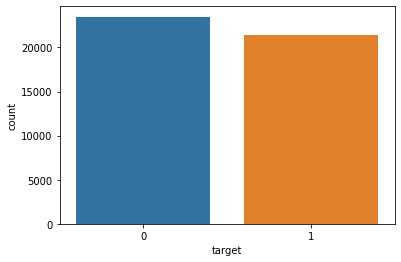

In [7]:
# Check the distribution of true and fake news

sns.countplot(df['target'])
plt.show()

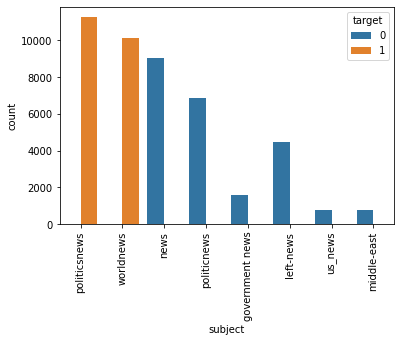

In [8]:
# Check the distribution of category based on the legitimacy of the news
sns.countplot(x='subject',hue='target',data=df)
plt.xticks(rotation=90)
plt.show()

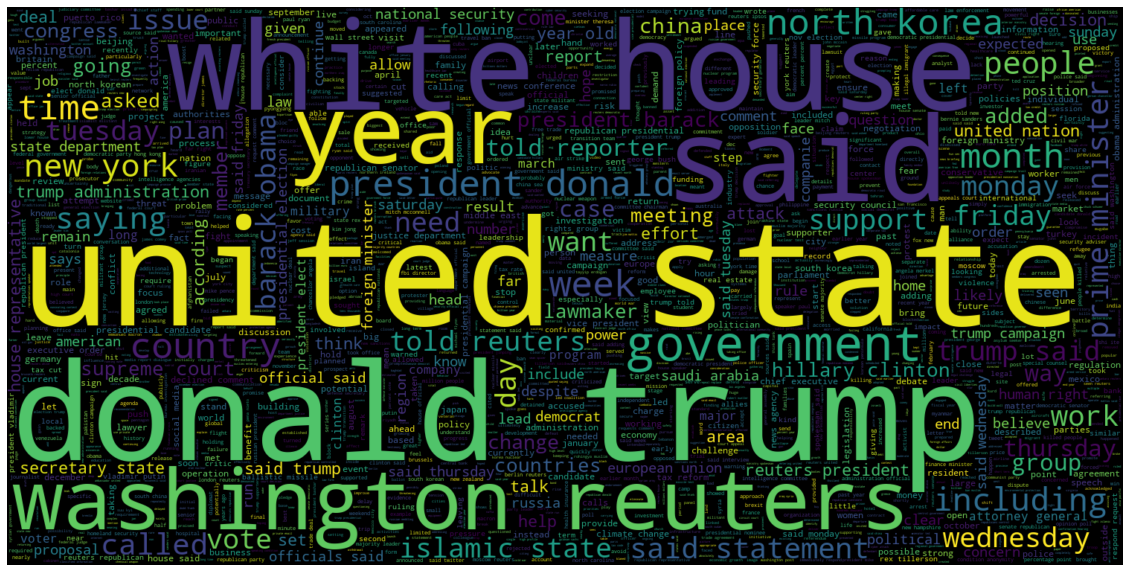

In [9]:
# Wordcloud for real news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2500 , width = 1500 , height = 750).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

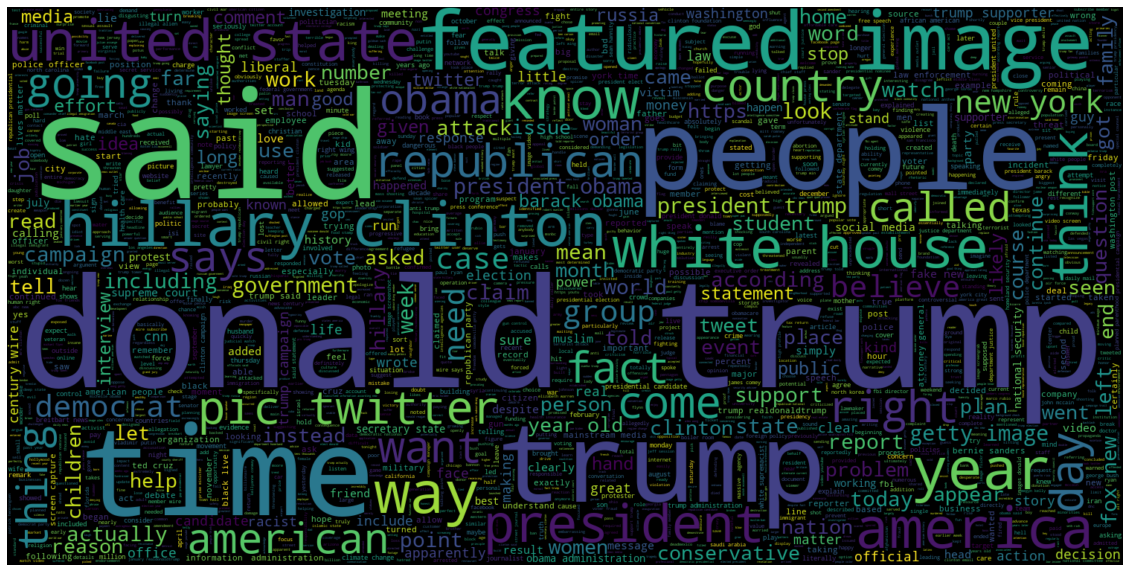

In [10]:
# Wordcloud for fake news
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2500 , width = 1500 , height = 750).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

In [11]:
# We will train the model based on the text of the article

X = df['clean_joined_text']
y = df['target']
vec_train = CountVectorizer().fit(X)
X_vec = vec_train.transform(X)

#Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=1)


#random forest model
rfmodel=RandomForestClassifier(random_state=1, n_jobs=-1)
rfmodel.fit(X_train, y_train)
predicted_value = rfmodel.predict(X_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9906907194303374


In [12]:
# Predict recent Fox article on president Biden using random forest model

url='https://www.foxnews.com/politics/photos-biden-cheat-sheets-first-formal-press-conference'

# Define a function based on newspaper package to get news article from a link
def get_article(x):
    article = Article(x)
    article.download()
    article.parse()
    article.nlp()
    x = article.text
    result = []
    for token in gensim.utils.simple_preprocess(x):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
    y = [" ".join(result)]   
    return y

X = get_article(url)
new_vec = vec_train.transform(X)
rfmodel.predict(new_vec)[0]

0

In [5]:
# model using LSTM
#first tokenize the data
X = df['clean_joined_text']
y = df['target']

vocab_size = 100000
embedding_dim = 16
max_length = 500
tokenizer = Tokenizer(num_words=vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# pad the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre', maxlen=max_length)

# build model
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
lstm_model.add(Bidirectional(RNN(LSTMCell(128))))

# add a dropout layer to prevent overfitting
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history =  lstm_model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 35918 samples, validate on 8980 samples
Epoch 1/10
35918/35918 [==============================] - 494s 14ms/sample - loss: 0.1545 - accuracy: 0.9396 - val_loss: 0.0501 - val_accuracy: 0.9875
Epoch 2/10
35918/35918 [==============================] - 497s 14ms/sample - loss: 0.0737 - accuracy: 0.9758 - val_loss: 0.0770 - val_accuracy: 0.9757
Epoch 3/10
35918/35918 [==============================] - 499s 14ms/sample - loss: 0.0256 - accuracy: 0.9925 - val_loss: 0.0307 - val_accuracy: 0.9924
Epoch 4/10
35918/35918 [==============================] - 496s 14ms/sample - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0441 - val_accuracy: 0.9899
Epoch 5/10
35918/35918 [==============================] - 498s 14ms/sample - loss: 0.0426 - accuracy: 0.9867 - val_loss: 0.0787 - val_accuracy: 0.9790
Epoch 6/10
35918/35918 [==============================] - 495s 14ms/sample - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.1171 - val_accuracy: 0.9637
Epoch 7/10
35918/35918 [=====================

In [11]:
# Predict if a recent CNN article on North Korea is true or not
X = get_article('https://edition.cnn.com/2021/03/24/world/north-korea-missiles-intl/index.html')
test_dat = tokenizer.texts_to_sequences(X)
test_dat = tf.keras.preprocessing.sequence.pad_sequences(test_dat, padding='pre', maxlen=max_length)
z=lstm_model.predict(test_dat)
z[0][0]

0.97875094